In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re

import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())

import models
import dre
import rna
import vae
import designers
import utils
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

True


In [13]:
design_pkl_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-041124-copy.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)
    
design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-0.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata1 = pickle.load(f)

design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-0-part2.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata2 = pickle.load(f)


In [23]:
design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-0.pkl'
with open(design_pkl_fname, 'wb') as f:
    pickle.dump(name2designdata1, f)

In [ ]:
for name, thing in name2designdata1.items():
    print(name, thing[1], np.mean(thing[2]))

In [14]:
name2designdata1.update(name2designdata2)

In [15]:
for name in name2designdata:
    if name not in name2designdata1 and 't' not in name:
        print(name)

biswas-ridge-0.05
biswas-ridge-0.03
biswas-ff-0.05
biswas-ff-0.03
biswas-cnn-0.05
biswas-cnn-0.03


# label designs

In [11]:
# check sampling progress
design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-2.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)
    
for name in name2designdata:
    print(name)

In [6]:
# label designs sampled in rna-sample-092324.ipynb (need viennaenv)
for i in [9]:
    design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-{}.pkl'.format(i)
    rna.label_design_sequences(design_pkl_fname)

Using landscape with binding target 0, seed sequence 3, and noise SD 0.02.
Loading/saving labeled name2designdata to /data/wongfanc/rna-results/designs-n10k-092324-9.pkl
Getting labels for cbas-ridge-0.1t19...
  Mean prediction: 0.295, mean label: 0.295. (329 s)

Getting labels for cbas-ridge-0.2t19...
  Mean prediction: 0.301, mean label: 0.301. (661 s)

Getting labels for cbas-ridge-0.3t19...
  Mean prediction: 0.302, mean label: 0.302. (994 s)

Getting labels for cbas-ridge-0.4t19...
  Mean prediction: 0.310, mean label: 0.310. (1327 s)

Getting labels for cbas-ridge-0.5t19...
  Mean prediction: 0.310, mean label: 0.310. (1660 s)

Getting labels for cbas-ridge-0.6t19...
  Mean prediction: 0.317, mean label: 0.316. (1994 s)

Getting labels for cbas-ridge-0.7t19...
  Mean prediction: 0.325, mean label: 0.324. (2329 s)

Getting labels for cbas-ridge-0.8t19...
  Mean prediction: 0.346, mean label: 0.344. (2667 s)

Getting labels for cbas-ridge-0.9t19...
  Mean prediction: 0.432, mean la

Getting labels for adalead-cnn-0.15...
  Mean prediction: 0.384, mean label: 0.378. (29678 s)

Getting labels for adalead-cnn-0.1...
  Mean prediction: 0.392, mean label: 0.388. (30022 s)

Getting labels for adalead-cnn-0.05...
  Mean prediction: 0.393, mean label: 0.387. (30367 s)

Getting labels for adalead-cnn-0.01...
  Mean prediction: 0.403, mean label: 0.410. (30719 s)

Getting labels for pex-cnn...
  Mean prediction: 0.337, mean label: 0.340. (31055 s)

Getting labels for biswas-cnn-0.02...
  Mean prediction: 0.331, mean label: 0.325. (31389 s)

Getting labels for biswas-cnn-0.015...
  Mean prediction: 0.342, mean label: 0.336. (31725 s)

Getting labels for biswas-cnn-0.01...
  Mean prediction: 0.361, mean label: 0.355. (32065 s)

Getting labels for biswas-cnn-0.005...
  Mean prediction: 0.389, mean label: 0.382. (32408 s)



# run PP selection experiments

In [2]:
# cannot contain any groups that don't have any data from name2designdata
# MDRE.fit() will throw error
mdre_group_regex_strs = [
    'adalead-ridge-0.\d',
    'adalead-ff-0.\d',
    'adalead-cnn-0.\d',
    'biswas-ridge-0.\d',
    'biswas-ff-0.\d',
    'biswas-cnn-0.\d',
    'dbas-ff-0.\d',
    'dbas-cnn-0.\d',
    'pex-ridge',
    'pex-ff',
    'pex-cnn',
    'dbas-ridge-0.1t\d',
    'dbas-ridge-0.2t\d',
    'cbas-ridge-0.1t\d',
    'cbas-ridge-0.2t\d',
    'cbas-ridge-0.3t\d',
    'cbas-ridge-0.4t\d',
    'cbas-ridge-0.5t\d',
    'cbas-ridge-0.6t\d',
    'cbas-ridge-0.7t\d',
    'cbas-ridge-0.8t\d',
    'cbas-ridge-0.9t\d',
    'cbas-ff-0.1',
    'cbas-ff-0.2',
    'cbas-ff-0.3',
    'cbas-ff-0.4',
    'cbas-ff-0.5',
    'cbas-ff-0.6',
    'cbas-ff-0.7',
    'cbas-ff-0.8',
    'cbas-ff-0.9',
    'cbas-cnn-0.1',
    'cbas-cnn-0.2',
    'cbas-cnn-0.3',
    'cbas-cnn-0.4',
    'cbas-cnn-0.5',
    'cbas-cnn-0.6',
    'cbas-cnn-0.7',
    'cbas-cnn-0.8',
    'cbas-cnn-0.9',
    'vae-ridge'
]

In [ ]:
reload(dre)
reload(rna)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
# cbas ridge
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    design_names.append(f'cbas-ridge-{q}t19')

# dbas ridge
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')
    

design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
cal_pkl_fname = '/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl'
target_values = np.arange(0.25, 0.501, 0.001)
n_trial = 200
n_mdre_hidden = 200
n_mdre_epoch = 200
results_csv_fname = '/data/wongfanc/rna-results/selection-pp-100324.csv'
device = torch.device('cuda')

df = rna.run_pp_selection_experiments(
    design_names,
    design_pkl_fname,
    model_and_data_fname_no_ftype,
    cal_pkl_fname,
    mdre_group_regex_strs,
    target_values,
    n_trial,
    n_mdre_hidden=n_mdre_hidden,
    n_mdre_epoch=n_mdre_epoch,
    results_csv_fname=results_csv_fname,
    device=device,
)

# run imputation selection experiments

In [2]:
reload(dre)
reload(rna)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
    
    # CbAS
    for q in cbas_dbas_quantiles:
        q = round(q, 2)
        design_names.append(f'cbas-{model_name}-{q}')
        
    # dbas
    if model_name != 'ridge':
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')
            
print(f'Testing {len(design_names)} design names:')
for name in design_names:
    print(f'  {name}')
    

n_trial = 10
design_pkl_fname_no_trial = '/data/wongfanc/rna-results/designs-n10k-092324'
model_and_data_fname_no_ftype = 'n10000-nsd0.02-h100-092324'
target_values = np.arange(0.25, 0.501, 0.001)
results_csv_fname = '/data/wongfanc/rna-results/selection-imputation-102124.csv'

df, name2truemeans = rna.run_imputation_selection_experiments(
    design_names,
    n_trial=n_trial,
    design_pkl_fname_no_trial=design_pkl_fname_no_trial,
    model_and_data_fname_no_ftype=model_and_data_fname_no_ftype,
    target_values=target_values,
    results_csv_fname=results_csv_fname,
)

Testing 96 design names:
  vae-ridge
  dbas-ridge-0.1
  dbas-ridge-0.2
  adalead-ridge-0.5
  adalead-ridge-0.45
  adalead-ridge-0.4
  adalead-ridge-0.35
  adalead-ridge-0.3
  adalead-ridge-0.25
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  cbas-ridge-0.1
  cbas-ridge-0.2
  cbas-ridge-0.3
  cbas-ridge-0.4
  cbas-ridge-0.5
  cbas-ridge-0.6
  cbas-ridge-0.7
  cbas-ridge-0.8
  cbas-ridge-0.9
  adalead-ff-0.5
  adalead-ff-0.45
  adalead-ff-0.4
  adalead-ff-0.35
  adalead-ff-0.3
  adalead-ff-0.25
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cbas-ff-0.5
  cbas-ff-0.6
  cbas-ff-0.7
  cbas-ff-0.8
  cbas-ff-0.9
  dbas-ff-0.1
  dbas-ff-0.2
  dbas-ff-0.3
  dbas-ff-0.4
  

No design data for cbas-ridge-0.1t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.1t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.2t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.2t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data f

# imputation exceedance

In [21]:
# load training data
reload(models)

threshold = 0.4
train_fname = '/data/wongfanc/rna-models/traindata-n10000-nsd0.02-h100-092324.npz'
d = np.load(train_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n'] >= threshold

# train exceedance model
# NOPE, need classifier model
model = models.FeedForward(
    50,
    utils.RNA_NUCLEOTIDES,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model.fit(trainseq_n, ytrain_n)

No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.


100%|███████████████████████████████████████████████████| 141/141 [00:00<00:00, 187.19it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.03. 1 sec.


100%|███████████████████████████████████████████████████| 141/141 [00:00<00:00, 235.97it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████| 141/141 [00:00<00:00, 234.27it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████| 141/141 [00:00<00:00, 221.15it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████| 141/141 [00:00<00:00, 226.05it/s]

Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.


array([[0.00122763, 0.02792969],
       [0.00055578, 0.00101318],
       [0.00054853, 0.00100704],
       [0.00054333, 0.00100674],
       [0.00054208, 0.0010057 ]])

In [5]:
reload(rna)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
    
    # CbAS
    for q in cbas_dbas_quantiles:
        q = round(q, 2)
        design_names.append(f'cbas-{model_name}-{q}')
        
    # dbas
    if model_name != 'ridge':
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')
            
print(f'Testing {len(design_names)} design names:')
for name in design_names:
    print(f'  {name}')
    

n_trial = 10
design_pkl_fname_no_trial = '/data/wongfanc/rna-results/designs-n10k-092324'
model_and_data_fname_no_ftype = 's'
target_values = np.arange(0., 1.01, 0.01)
threshold = 0.4
results_csv_fname = '/data/wongfanc/rna-results/selection-imputation-exceed{:.2f}-121824.csv'

df, name2truemeans = rna.run_imputation_exceedance_selection_experiments(
    design_names,
    threshold,
    model,
    n_trial=n_trial,
    design_pkl_fname_no_trial=design_pkl_fname_no_trial,
    model_and_data_fname_no_ftype=model_and_data_fname_no_ftype,
    target_values=target_values,
    imp_csv_fname=results_csv_fname,
)

Testing 78 design names:
  vae-ridge
  dbas-ridge-0.1
  dbas-ridge-0.2
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  cbas-ridge-0.1
  cbas-ridge-0.2
  cbas-ridge-0.3
  cbas-ridge-0.4
  cbas-ridge-0.5
  cbas-ridge-0.6
  cbas-ridge-0.7
  cbas-ridge-0.8
  cbas-ridge-0.9
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cbas-ff-0.5
  cbas-ff-0.6
  cbas-ff-0.7
  cbas-ff-0.8
  cbas-ff-0.9
  dbas-ff-0.1
  dbas-ff-0.2
  dbas-ff-0.3
  dbas-ff-0.4
  dbas-ff-0.5
  dbas-ff-0.6
  dbas-ff-0.7
  dbas-ff-0.8
  dbas-ff-0.9
  adalead-cnn-0.2
  adalead-cnn-0.15
  adalead-cnn-0.1
  adalead-cnn-0.05
  adalead-cnn-0.01
  biswas-cnn-0.02
  biswas-cnn-0.015
  biswas-cnn-0.01
  biswas-cnn

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:748: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = (value1 - value2 - diff) / std_diff
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:748: RuntimeWarning: invalid value encountered in scalar divide
  zstat = (value1 - value2 - diff) / std_diff


No design data for cbas-ridge-0.1t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.1t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.2t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.2t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data f

No design data for cbas-ridge-0.1t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.1t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.2t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.2t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for cbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data f

In [8]:
impworst_v, imperr_v, impdisc_v, impval2configs = utils.process_rna_selection_experiments(
    df, target_values, design_names, name2truemeans, n_trial, imp_or_pp='imp', alpha=0.1
)

Processing imp results with the following menu of size 78, 101 target values in [0.00, 1.00], 10 trials, and alpha = 0.1:
  vae-ridge
  dbas-ridge-0.1
  dbas-ridge-0.2
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  cbas-ridge-0.1
  cbas-ridge-0.2
  cbas-ridge-0.3
  cbas-ridge-0.4
  cbas-ridge-0.5
  cbas-ridge-0.6
  cbas-ridge-0.7
  cbas-ridge-0.8
  cbas-ridge-0.9
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cbas-ff-0.5
  cbas-ff-0.6
  cbas-ff-0.7
  cbas-ff-0.8
  cbas-ff-0.9
  dbas-ff-0.1
  dbas-ff-0.2
  dbas-ff-0.3
  dbas-ff-0.4
  dbas-ff-0.5
  dbas-ff-0.6
  dbas-ff-0.7
  dbas-ff-0.8
  dbas-ff-0.9
  adalead-cnn-0.2
  adalead-cnn-0.15
  adalead-cnn-0.1
  adalea

Done processing 20 / 101 target values (0 s)
Done processing 40 / 101 target values (0 s)
Done processing 60 / 101 target values (1 s)
Done processing 80 / 101 target values (1 s)
Done processing 100 / 101 target values (1 s)
Done processing (1 s)


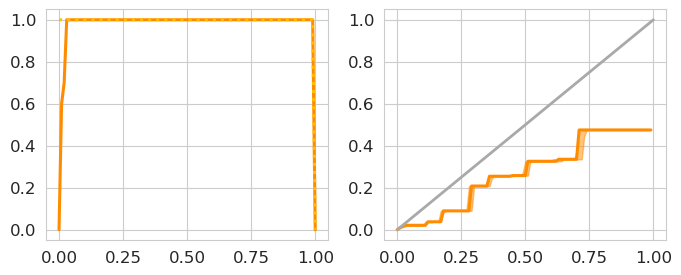

In [19]:
imp_color = 'darkorange'
lw = 2.2
q_low = 0.2
q_high = 0.8

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(target_values, imperr_v, c=imp_color, linewidth=lw);
plt.plot(target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=lw);

plt.subplot(122)
plt.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only', linewidth=lw,
)
plt.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
);
plt.plot([0, 1.], [0, 1.], '-', c='darkgray', alpha=1, linewidth=2);
